# Transform Secrets Engine

Transform is a Secret Engine that allows Vault to encode and decode sensitive values residing in external systems such as databases or file systems.

This secret engine currently supports `fpe`, `masking` and `tokenization` as data transformation types.

<img src=images/vault-transform-1.png width="800">

Ultra-sensitive information, such as credit card numbers are commonly protected using tokenization where sensitive data is substituted by non-sensitive data called the token.

This secrets engine requires Vault Enterprise with Advanced Data Protection module.

## Diagram

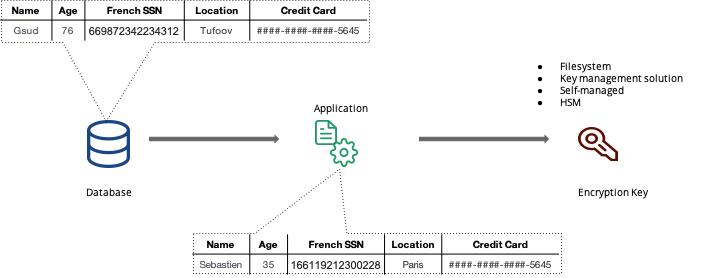

## Vault Setup

We are going to stand up a single-node Vault cluster running in `dev` mode. Customize the values as appropriate. Common ways to change are `VAULT_TOKEN_PRIMARY` and `VAULT_PORT`.

> NOTE: I change the port because I sometimes run multiple instance of Vault on the same machine.

In [1]:
export VAULT_PORT=8201 #8200 is default
export VAULT_ADDR=http://127.0.0.1:${VAULT_PORT:=8200}
export VAULT_TOKEN_PRIMARY=myroot #used to keep track of root token
printf "VAULT TOKEN for root is: $VAULT_TOKEN_PRIMARY \n"
export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY:=root}
printf "\n#==> Please Run: export VAULT_TOKEN=${VAULT_TOKEN_PRIMARY}\n"
printf "VAULT_ADDR=${VAULT_ADDR}"

VAULT TOKEN for root is: myroot 

#==> Please Run: export VAULT_TOKEN=myroot
VAULT_ADDR=http://127.0.0.1:8201

In [2]:
docker run --rm -d \
    --name vault_vin \
    -e VAULT_ADDR=http://127.0.0.1:8200 \
    -e VAULT_TOKEN=${VAULT_TOKEN_PRIMARY} \
    -e VAULT_DEV_ROOT_TOKEN_ID=${VAULT_TOKEN_PRIMARY} \
    -e VAULT_LICENSE=$(cat vault.hclic) \
    -p ${VAULT_PORT:=8201}:8200 \
    --cap-add IPC_LOCK \
    hashicorp/vault-enterprise:1.10.0-ent

992be35c202ef6157afbfca5d533719f648f4946518b6aa953b2bbcd934dbc5b


> The `VAULT_ADDR` for the host machine uses the port you specify. The container itself uses the default port of 8200.

Verify the docker cotainer `vault_vin` is running.

In [3]:
docker ps | grep vault_vin

992be35c202e   hashicorp/vault-enterprise:1.10.0-ent     "docker-entrypoint.s…"   Less than a second ago   Up Less than a second   0.0.0.0:8201->8200/tcp, :::8201->8200/tcp                                                                                                                                                                                                                       vault_vin


Run this command to stop the container. NOTE: The container is configured to remove itself when stopped `--rm`.

In [4]:
# docker stop vault_vin

Quick check

In [5]:
docker exec -it vault_vin vault status

Key             Value
---             -----
Seal Type       shamir
Initialized     true
Sealed          false
Total Shares    1
Threshold       1
Version         1.10.0+ent
Storage Type    inmem
Cluster Name    vault-cluster-c102457e
Cluster ID      a62291c0-5867-fa93-3e84-c0be1fb78fdd
HA Enabled      false


Confirm license.

In [6]:
vault read sys/license -format=json | jq .data.features

[
  "HSM",
  "Performance Replication",
  "DR Replication",
  "MFA",
  "Sentinel",
  "Seal Wrapping",
  "Control Groups",
  "Performance Standby",
  "Namespaces",
  "KMIP",
  "Entropy Augmentation",
  "Transform Secrets Engine",
  "Lease Count Quotas",
  "Key Management Secrets Engine",
  "Automated Snapshots",
  "Key Management Transparent Data Encryption"
]


**NOTE**: Make sure you are licensed for "`Transform Secrets Engine`" feature.

## Roles, Transformations, Templates and Alphabets

The Transform secrets engine contains several types resources that encapsulates different aspects of information required to perform transformation.  
  
**Transformations** - holds a particular transformation. It contains information about the type of transformation, template it should use for value detection, and other values such as tweak source or the masking character to use.
  
**Templates** - allow us to determine what and how to capture the value we want to transform
  
**Alphabets** - set of valid UTF-8 character contained within the input and transformed value on FPE transformations

**Roles** - holds the set of transformation allowed.  The role name is provided when performing encode and decode

<img src=images/vault-transform-3.png width="600">

## Format Preserving Encryption for Credit Card Numbers

Information is obfuscated in such a way that it is compliant with data constraints in systems of record and decoded as needed.

The following is an advanced Transform secrets engine workflow.
1. Enable the `transform` secrets engine
1. Create a `role` containing the transformations that it can perform
1. Create an `alphabet` defining a set of characters to use for format-preserving encryption (FPE) if not using the built-in alphabets.
1. Create a `template` defining the rules for value matching if not using the built-in template
1. Create a `transformation` to specify the nature of the data manipulations 

### Enable the transform secrets engine

In [7]:
vault secrets enable transform || true

Success! Enabled the transform secrets engine at: transform/


In [8]:
vault secrets list

Path          Type         Accessor              Description
----          ----         --------              -----------
cubbyhole/    cubbyhole    cubbyhole_be6b7c69    per-token private secret storage
identity/     identity     identity_3ba32417     identity store
secret/       kv           kv_c034b84e           key/value secret storage
sys/          system       system_2fdd9106       system endpoints used for control, policy and debugging
transform/    transform    transform_ca751154    n/a


### Create custom alphabet

Alphabet defines a set of characters (UTF-8) that is used for FPE to determine the validity of plaintext and ciphertext values.

Create an alphabet named `numerics`.

In [9]:
vault write transform/alphabet/numerics alphabet="0123456789"

Success! Data written to: transform/alphabet/numerics


Verify the alphabet.

In [10]:
vault read transform/alphabet/numerics

Key         Value
---         -----
alphabet    0123456789


List existing alphabets.

In [11]:
vault list transform/alphabet

Keys
----
builtin/alphalower
builtin/alphanumeric
builtin/alphanumericlower
builtin/alphanumericupper
builtin/alphaupper
builtin/numeric
numerics


### Create custom template

Templates define the data format patterns that you wish to keep while transforming the secrets. In this section, you are going to create a transformation template which encodes British passport numbers.

Create a template named `ccn`. This template uses the `numerics` template.

In [12]:
vault write transform/template/ccn \
  type=regex \
  pattern='(\d{4})-(\d{4})-(\d{4})-(\d{4})' \
  alphabet=numerics

Success! Data written to: transform/template/ccn


Verify template.

In [13]:
vault read transform/template/ccn

Key               Value
---               -----
alphabet          numerics
decode_formats    map[]
encode_format     n/a
pattern           (\d{4})-(\d{4})-(\d{4})-(\d{4})
type              regex


List existing templates.

In [14]:
vault list transform/template

Keys
----
builtin/creditcardnumber
builtin/socialsecuritynumber
ccn


### Create a transformation

Create a transformation named "`card-number`" which will be used to transform credit card numbers. This uses the built-in template builtin/creditcardnumber to perform format-preserving encryption (FPE). The allowed role to use this transformation is payments, which you just created.

In [15]:
vault write transform/transformation/ccn-fpe \
  type=fpe \
  template=ccn \
  tweak_source=internal \
  allowed_roles=*

Success! Data written to: transform/transformation/ccn-fpe


List existing transformations.

In [16]:
vault list transform/transformation

Keys
----
ccn-fpe


### Create a Role

In [17]:
vault write transform/role/payments transformations=ccn-fpe

Success! Data written to: transform/role/payments


List existing roles.

In [18]:
vault list transform/role

Keys
----
payments


### Transform it
After the secrets engine is configured and a user/machine has a Vault token, it can use this secret engine to encode and decode input values

Encode a credit card number.

In [19]:
mkdir -p /tmp/vault
vault write transform/encode/payments -format=json value="1111-2222-3333-4444" \
    | tee /tmp/vault/vault_transform.txt
TRANSFORM_ENCODED=$(jq -r .data.encoded_value /tmp/vault/vault_transform.txt)
printf "\nTRANSFORM_ENCODED=${TRANSFORM_ENCODED}\n"

{
  "request_id": "bde4bc43-3cb4-6e38-48c3-d1c144df96bc",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "encoded_value": "1798-4387-3871-1198"
  },
  "warnings": null
}

TRANSFORM_ENCODED=1798-4387-3871-1198


<details><summary><b>Sample Output</b></summary>

```shell
{
  "request_id": "b4ef8dc0-89d4-e5a8-9caf-ae732e4ba9c4",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "encoded_value": "2533-2081-4554-4019"
  },
  "warnings": null
}
```
</details>

#### Decode some input value using the /decode endpoint with a named role:

In [20]:
vault write transform/decode/payments value="${TRANSFORM_ENCODED}"

Key              Value
---              -----
decoded_value    1111-2222-3333-4444


### Masking Credit Card

Data masking is another way to obfuscate information. In this case, though, the data is masked and cannot be decoded once it's encoded.

In this scenario, we are going to mask the first 12 number of a credit card and leave the last 4 unchanged.

Create a transformation called "`ccn-mask`".
- used to transform credit card numbers
- uses template "`ccn`" to perform FPE
- roles allowed are "`*`"

In [21]:
vault write transform/transformation/ccn-mask \
  type=masking \
  template="ccn-partial" \
  masking_character=X \
  allowed_roles=*

Success! Data written to: transform/transformation/ccn-mask


Create custom template

In [22]:
vault write transform/template/ccn-partial \
  type=regex \
  pattern='(\d{4})-(\d{4})-(\d{4})-\d{4}' \
  alphabet=numerics

Success! Data written to: transform/template/ccn-partial


Create a role specifying the transormations that it can perform.

In [23]:
vault write transform/role/mask transformations=ccn-mask

Success! Data written to: transform/role/mask


In [24]:
vault write transform/encode/mask value=1111-2222-3333-4444 

Key              Value
---              -----
encoded_value    XXXX-XXXX-XXXX-4444


**This is the end of the Credit Card scenario**

---

## Format Preserving Encryption for Car VIN

In [25]:
sample_vin=1G4AJ47A0BH191698
# template1: ([A-H|J-N|P|R-Z|0-9]{3})([A-H|J-N|P|R-Z|0-9]{5})([A-H|J-N|P|R-T|V-Y|0-9]{1})
# template2: ([A-H|J-N|P|R-T|V-Y|0-9]{1})([A-H|J-N|P|R-Z|0-9]{1})(\d{6})
# template: ([A-H|J-N|P|R-Z|0-9]{11})(\w{6})

In [26]:
echo ${sample_vin}

1G4AJ47A0BH191698


### Enable the transform secrets engine - Car

1. Enable secrets engine: `transform_car`
1. Create custom alphabet: `vin`
1. Create custom template: `car_vin`
1. Create transformation: `car_vin`
1. Create role: `car`
1. Test encode with `admin` token.
1. Test decode with `admin` token.

In [27]:
printf "#==> Set mount path\n"
transform_secret_mount=transform_car

printf "\n#==> Enable secrets engine\n"
vault secrets enable -path=${transform_secret_mount} transform || true

printf "\n#==> Create custom alphabet\n"
vault write ${transform_secret_mount}/alphabet/vin \
    alphabet="ABCDEFGHJKLMNPRSTUVWXYZabcdefghjklmnprstuvwxyz0123456789"

printf "\n#==> Create custom template\n"
vault write ${transform_secret_mount}/template/car_vin \
  type=regex \
  pattern='([A-H|J-N|P|R-Z|a-h|j-n|p|r-z|0-9]{11})(\w{6})' \
  alphabet=vin \
  encode_format='$1$2'

printf "\n#==> Create transformation\n"
vault write ${transform_secret_mount}/transformation/car_vin \
  type=fpe \
  template=car_vin \
  tweak_source=internal \
  allowed_roles=*

vault read ${transform_secret_mount}/transformation/car_vin

printf "\n#==> Create transform role\n"
vault write ${transform_secret_mount}/role/car \
    transformations=car_vin,car_location

printf "\n#==> Encode it\n"
vault write ${transform_secret_mount}/encode/car -format=json \
    value=${sample_vin} transformation=car_vin \
    | tee /tmp/vault/vault_transform_vin.txt
TRANSFORM_ENCODED=$(jq -r .data.encoded_value /tmp/vault/vault_transform_vin.txt)
printf "\nencoded_value=${TRANSFORM_ENCODED}\n"

printf "\n#==> Decode it\n"
vault write ${transform_secret_mount}/decode/car -format=json \
    value="${TRANSFORM_ENCODED}" transformation=car_vin \
    | tee /tmp/vault/vault_transform_decoded_vin.txt
decoded_value=$(jq -r .data.decoded_value /tmp/vault/vault_transform_decoded_vin.txt)
printf "\ndecoded_value=${decoded_value}\n"

#==> Set mount path

#==> Enable secrets engine
Success! Enabled the transform secrets engine at: transform_car/

#==> Create custom alphabet
Success! Data written to: transform_car/alphabet/vin

#==> Create custom template
Success! Data written to: transform_car/template/car_vin

#==> Create transformation
Success! Data written to: transform_car/transformation/car_vin
Key              Value
---              -----
allowed_roles    [*]
template         car_vin
templates        [car_vin]
tweak_source     internal
type             fpe

#==> Create transform role
Success! Data written to: transform_car/role/car

#==> Encode it
{
  "request_id": "a6d9655b-20af-360e-0cd2-e4485a5e1c82",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "encoded_value": "HpvBwsVJfYrJYdpdV"
  },
  "warnings": null
}

encoded_value=HpvBwsVJfYrJYdpdV

#==> Decode it
{
  "request_id": "98668eb1-a0a4-e1bd-b1b9-45a68f8f3c42",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,

## Testing Car VIN Scenario

1. Create policies to allow transform `encode` and `decode`.
1. Enable Approle auth engine: `appfole_car`
1. Create and test Approle role: `car_encode`
1. Create and test Approle role: `car_decode`

### Create policies for transform encode and decode

Create a policy to allow performing a transform `encode`. Create another policy to allow performing a transform `decode`.

In [28]:
vault policy write car_encode - <<EOF
# To request data encoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "${transform_secret_mount}/encode/*" {
   capabilities = [ "update" ]
}
EOF

vault policy write car_decode - <<EOF
# To request data decoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "${transform_secret_mount}/decode/*" {
   capabilities = [ "update" ]
}
EOF

Success! Uploaded policy: car_encode
Success! Uploaded policy: car_decode


Verify the policies were created correctly.

In [29]:
vault policy read car_encode

# To request data encoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform_car/encode/*" {
   capabilities = [ "update" ]
}


In [30]:
vault policy read car_decode

# To request data decoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform_car/decode/*" {
   capabilities = [ "update" ]
}


### Enable auth engine - approle

In [31]:
approle_auth_mount=approle_car

In [32]:
vault auth enable -path=${approle_auth_mount} approle || true

Success! Enabled approle auth method at: approle_car/


### Create and test `car_encode` role

#### Configure auth engine - approle

In [33]:
approle_role=car_encode
vault write -force auth/${approle_auth_mount}/role/${approle_role} \
    secret_id_ttl=10m \
    token_num_uses=10 \
    token_ttl=20m \
    token_max_ttl=30m \
    secret_id_num_uses=40 \
    token_policies=${approle_role}

Success! Data written to: auth/approle_car/role/car_encode


In [34]:
vault read auth/${approle_auth_mount}/role/${approle_role}

Key                        Value
---                        -----
bind_secret_id             true
local_secret_ids           false
secret_id_bound_cidrs      <nil>
secret_id_num_uses         40
secret_id_ttl              10m
token_bound_cidrs          []
token_explicit_max_ttl     0s
token_max_ttl              30m
token_no_default_policy    false
token_num_uses             10
token_period               0s
token_policies             [car_encode]
token_ttl                  20m
token_type                 default


#### Configure auth engine role

In [35]:
VAULT_ROLE_ID=$(vault read -field role_id \
    auth/${approle_auth_mount}/role/${approle_role}/role-id) \
    && echo $VAULT_ROLE_ID

74ba24eb-4550-4776-6c52-f57a92659905


In [36]:
VAULT_SECRET_ID=$(vault write -f -format=json \
    auth/${approle_auth_mount}/role/${approle_role}/secret-id | jq -r .data.secret_id) \
    && echo ${VAULT_SECRET_ID}

a3bc9663-c54c-7d8a-277f-5f2049ea1fba


#### Verify auth engine - approle

Log in with `car_encode` role.

In [37]:
APP_TOKEN=$(vault write -field token auth/${approle_auth_mount}/login \
  role_id=${VAULT_ROLE_ID} \
  secret_id=${VAULT_SECRET_ID}) \
  && echo $APP_TOKEN

hvs.CAESII_SFF24YIr4K3-rfhV8LfCFCMeKO1JtFo1eucRK1L7NGh4KHGh2cy5jaVZBTDBzeHk4eEQ4YVp5Rm05Y1lYRHk


In [38]:
VAULT_TOKEN=${APP_TOKEN} vault token lookup

Key                 Value
---                 -----
accessor            YnbfKqMPKZKX33r7vgZyu9LL
creation_time       1648680294
creation_ttl        20m
display_name        approle_car
entity_id           fc6deebd-a77e-7764-75cc-e64e2d1046ac
expire_time         2022-03-30T23:04:54.649866521Z
explicit_max_ttl    0s
id                  hvs.CAESII_SFF24YIr4K3-rfhV8LfCFCMeKO1JtFo1eucRK1L7NGh4KHGh2cy5jaVZBTDBzeHk4eEQ4YVp5Rm05Y1lYRHk
issue_time          2022-03-30T22:44:54.649870589Z
meta                map[role_name:car_encode]
num_uses            9
orphan              true
path                auth/approle_car/login
policies            [car_encode default]
renewable           true
ttl                 19m59s
type                service


<br>
Confirm the following:

- `meta` is `map[role_name:car_encode]`
- `policies` is `[car_encode default]`

Sample Output
```shell
Key                 Value
---                 -----
accessor            dZP83z4KUHIX43KVLRxkmdn6
creation_time       1648654237
creation_ttl        20m
display_name        approle_car
entity_id           7c057537-a782-e2a2-d443-197658a379e5
expire_time         2022-03-30T15:50:37.058530382Z
explicit_max_ttl    0s
id                  hvs.CAESIFH0-lTa0KW9aYdGftmCtj0D1dd2pQmfAf99OewJeTIeGiEKHGh2cy5GVlFoQ1BlYjFPQk5OWG1OZTdsd0VBYUkQ7w0
issue_time          2022-03-30T15:30:37.058546964Z
meta                map[role_name:car_encode]
num_uses            9
orphan              true
path                auth/approle_car/login
policies            [car_encode default]
renewable           true
ttl                 18m58s
type                service
```
<br>

**Positive Test** - Confirm `car_encode` role can `encode`.

In [39]:
VAULT_TOKEN=${APP_TOKEN} vault write ${transform_secret_mount}/encode/car -format=json \
    value=1G4AJ47A0BH191698 transformation=car_vin \
    | tee /tmp/vault/vault_transform_vin.txt
TRANSFORM_ENCODED=$(jq -r .data.encoded_value /tmp/vault/vault_transform_vin.txt)
printf "\nTRANSFORM_ENCODED=${TRANSFORM_ENCODED}\n"

VAULT_TOKEN=${APP_TOKEN} vault write ${transform_secret_mount}/encode/car \
    value=1G4AJ47A0BH191698 transformation=car_vin

{
  "request_id": "bc057e0b-b6d8-2f1e-6367-dfdbf02c9ce3",
  "lease_id": "",
  "lease_duration": 0,
  "renewable": false,
  "data": {
    "encoded_value": "HpvBwsVJfYrJYdpdV"
  },
  "warnings": null
}

TRANSFORM_ENCODED=HpvBwsVJfYrJYdpdV
Key              Value
---              -----
encoded_value    HpvBwsVJfYrJYdpdV


**Negative Test** - Confirm `car_encode` role can NOT `decode`.

In [40]:
VAULT_TOKEN=${APP_TOKEN} vault write ${transform_secret_mount}/decode/car \
    value="${TRANSFORM_ENCODED}"

Error writing data to transform_car/decode/car: Error making API request.

URL: PUT http://127.0.0.1:8201/v1/transform_car/decode/car
Code: 403. Errors:

* 1 error occurred:
	* permission denied




: 2

<details><summary><b>Sample Output</b></summary>

```shell
Error writing data to transform_car/decode/car: Error making API request.

URL: PUT http://127.0.0.1:8200/v1/transform_car/decode/car
Code: 403. Errors:

* 1 error occurred:
	* permission denied
EOF
```

### Create and test `car_decode`

In [41]:
approle_role=car_decode
printf "#==> Create Approle Role\n"
vault write -force auth/${approle_auth_mount}/role/${approle_role} \
    secret_id_ttl=10m \
    token_num_uses=10 \
    token_ttl=20m \
    token_max_ttl=30m \
    secret_id_num_uses=40 \
    token_policies=${approle_role}

printf "\n#==> Create Approle Role ID\n"
VAULT_ROLE_ID=$(vault read -field role_id auth/${approle_auth_mount}/role/${approle_role}/role-id) \
  && echo $VAULT_ROLE_ID

printf "\n#==> Create Approle Role Secret\n"
VAULT_SECRET_ID=$(vault write -f -format=json auth/${approle_auth_mount}/role/${approle_role}/secret-id | jq -r .data.secret_id) \
  && echo ${VAULT_SECRET_ID}
APP_TOKEN=$(vault write -field token auth/${approle_auth_mount}/login \
  role_id=${VAULT_ROLE_ID} \
  secret_id=${VAULT_SECRET_ID}) \
  && echo $APP_TOKEN

printf "\n#==> Verify token\n"
VAULT_TOKEN=${APP_TOKEN} vault token lookup

#==> Create Approle Role
Success! Data written to: auth/approle_car/role/car_decode

#==> Create Approle Role ID
ce8ef665-3b13-d95b-32ef-02b328b3a7c6

#==> Create Approle Role Secret
e66314df-0575-7caa-a5d0-33aad21a04e4
hvs.CAESIFQyRTKRxcb05jKsLe-20TZpCD_faHJidGNOUGm1qPswGh4KHGh2cy5PQVo0VzJqUkRFNVhhTkZHWVV2V1U5cWY

#==> Verify token
Key                 Value
---                 -----
accessor            Mm2FGRvZqEhf9Xy1K10uXVYO
creation_time       1648680325
creation_ttl        20m
display_name        approle_car
entity_id           28f699eb-f929-ea07-0b71-b5a7caa78aa4
expire_time         2022-03-30T23:05:25.214262998Z
explicit_max_ttl    0s
id                  hvs.CAESIFQyRTKRxcb05jKsLe-20TZpCD_faHJidGNOUGm1qPswGh4KHGh2cy5PQVo0VzJqUkRFNVhhTkZHWVV2V1U5cWY
issue_time          2022-03-30T22:45:25.214265594Z
meta                map[role_name:car_decode]
num_uses            9
orphan              true
path                auth/approle_car/login
policies            [car_decode default]
renewa

<br>
Confirm the following:

- `meta` is `map[role_name:car_encode]`
- `policies` is `[car_encode default]`

<details><summary><b>Sample Output</b></summary>

```shell
Key                 Value
---                 -----
accessor            cOy8BSQJ9Hzt7oCszjjDZKIu
creation_time       1648654615
creation_ttl        20m
display_name        approle_car
entity_id           f2abd935-5c1c-07ff-8e03-290c5cf26e30
expire_time         2022-03-30T15:56:55.929090353Z
explicit_max_ttl    0s
id                  hvs.CAESIM-tqpaGyJNMwrJi_N4H_YvS3WnBmwGbY4QSGgWGPDBIGiEKHGh2cy56Mkh4b0dNdUdld0lCcDhqNmtKT2VmMnAQ_g0
issue_time          2022-03-30T15:36:55.929097465Z
meta                map[role_name:car_decode]   <==---
num_uses            9
orphan              true
path                auth/approle_car/login
policies            [car_decode default]   <==---
renewable           true
ttl                 19m59s
type                service
```
</details>
<br>

#### **Positive Test** - Confirm `car_decode` role can `decode`.

In [42]:
VAULT_TOKEN=${APP_TOKEN} vault write ${transform_secret_mount}/decode/car \
    value="${TRANSFORM_ENCODED}" transformation=car_vin

Key              Value
---              -----
decoded_value    1G4AJ47A0BH191698


<details><summary><b>Sample Output</b></summary>

```shell
Key              Value
---              -----
decoded_value    1G4AJ47A0BH191698
```

#### **Negative Test** - Confirm `car_decode` role can NOT `encode`.

In [43]:
VAULT_TOKEN=${APP_TOKEN} vault write ${transform_secret_mount}/encode/car \
    value=1G4AJ47A0BH191698 transformation=car_vin

Error writing data to transform_car/encode/car: Error making API request.

URL: PUT http://127.0.0.1:8201/v1/transform_car/encode/car
Code: 403. Errors:

* 1 error occurred:
	* permission denied




: 2

<details><summary><b>Sample Output</b></summary>

```shell
Error writing data to transform/encode/car: Error making API request.

URL: PUT http://127.0.0.1:8200/v1/transform_car/encode/car
Code: 403. Errors:

* 1 error occurred:
	* permission denied
```

### Troubleshooting

When encoding, the template matched the VIN number. But encoded output, did not match the template. Modified the template to accept alphanumeric on the second group as well.

## Format Preserving Encryption for Singapore NRIC

In [ ]:
vault write transform/template/sg-nric \
  type=regex \
  pattern='[STFG]{1}(\d{7})[A-Z]{1}' \
  alphabet=builtin/numeric

In [ ]:
vault write transform/role/nric transformations=nric-fpe

In [ ]:
vault write transform/transformation/nric-fpe \
  type=fpe \
  template=sg-nric \
  tweak_source=internal \
  allowed_roles=nric

In [ ]:
vault write transform/encode/nric value=S7180802G transformation=nric-fpe

In [ ]:
vault write transform/decode/nric value=S4296568G transformation=nric-fpe

### Masking Singapore NRIC
Masking replaces matched characters on the input value with a desired character. 
Masking is unidirectional; therefore only encoding is supported.

In [ ]:
vault write transform/template/nric \
  type=regex \
  pattern='[STFG]{1}(\d{7})[A-Z]{1}' \
  alphabet=builtin/numeric

In [ ]:
vault write transform/role/nric transformations=nric-fpe,nric-mask,ccn-fpe

In [ ]:
vault write transform/transformation/nric-mask \
        type=masking \
        template="nric" \
        masking_character=X \
        allowed_roles=nric

In [ ]:
vault write transform/encode/nric value=S7180802G transformation="nric-mask"

## Batch Input Processing
You can send multiple secrets in a request payload as **batch_input** instead of invoking API multiple times.

In [ ]:
#tee input-multiple.json <<EOF
cat <<EOF > /tmp/vault/input-multiple.json
{
  "batch_input": [
    {
      "value": "1G4AJ47A0BH191698",
      "transformation": "car-fpe"
    },
    {
      "value": "S7780801G",
      "transformation": "nric-mask"
    },
    {
      "value": "1111-2222-3333-4444",
      "transformation": "ccn-fpe"
    }
  ]
}
EOF


In [ ]:
# export VAULT_TOKEN=root
curl -s --header "X-Vault-Token: $VAULT_TOKEN" \
     --request POST \
     --data @/tmp/vault/input-multiple.json \
     $VAULT_ADDR/v1/transform/encode/nric | jq ".data"

In [ ]:
#tee payload-batch.json <<EOF

cat <<EOF > /tmp/input-multiple.json
{
  "batch_input": [
    { "value": "1111-1111-1111-1111", "transformation": "ccn-fpe" },
    { "value": "2222-2222-2222-2222", "transformation": "ccn-fpe" },
    { "value": "3333-3333-3333-3333", "transformation": "ccn-fpe" },
    { "value": "4444-4444-4444-4444", "transformation": "ccn-fpe" }
  ]
}
EOF


In [ ]:
curl -s --header "X-Vault-Token: $VAULT_TOKEN" \
     --request POST \
     --data @/tmp/input-multiple.json \
     $VAULT_ADDR/v1/transform/encode/payments | jq ".data"

### View Vault via a browser
Open a web browser and visit http://127.0.0.1:8200/ui/vault

## End

# Clean Up

## Clean Up Car Scenario

In [ ]:
echo ${approle_auth_mount} 
echo ${transform_secret_mount}

In [ ]:
vault secrets disable ${transform_secret_mount}

In [ ]:
vault auth disable ${approle_auth_mount}

In [ ]:
vault secrets list | grep transform
vault auth list | grep app

In [ ]:
vault secrets disable transform
vault auth disable approle

## Stop and remove Vault

In [ ]:
docker stop vault_vin

# Resources

- https://medium.com/hashicorp-engineering/advanced-data-protection-with-hashicorp-vault-96839b6b22af
- https://www.vaultproject.io/api-docs/secret/transform
- https://www.vaultproject.io/docs/secrets/transform

# Command Summary

This is work in progress. Please disregard for now.

In [ ]:
# ```shell
printf "#==> Create namespace for transform mount\n"
vault namespace create coke

printf "\n#####################################################################\n"

printf "\n#==> Transform for FPE\n"
VAULT_NAMESPACE=coke vault secrets enable transform
VAULT_NAMESPACE=coke vault secrets list
VAULT_NAMESPACE=coke vault write transform/alphabet/numerics alphabet="0123456789"
VAULT_NAMESPACE=coke vault write transform/template/ccn \
  type=regex \
  pattern='(\d{4})-(\d{4})-(\d{4})-(\d{4})' \
  alphabet=numerics
VAULT_NAMESPACE=coke vault write transform/transformation/ccn-fpe \
  type=fpe \
  template=ccn \
  tweak_source=internal \
  allowed_roles=*
VAULT_NAMESPACE=coke vault write transform/role/payments transformations=ccn-fpe

printf "\n#==>Show the encoded credit card number.\n"
mkdir -p /tmp/vault
VAULT_NAMESPACE=coke vault write transform/encode/payments \
    -format=json value="1111-2222-3333-4444" \
    | tee /tmp/vault/vault_transform_fpe.txt
TRANSFORM_ENCODED=$(jq -r .data.encoded_value /tmp/vault/vault_transform_fpe.txt)
echo ${TRANSFORM_ENCODED}

printf "\n#==>Show the decoded credit card number.\n"
VAULT_NAMESPACE=coke vault write transform/decode/payments \
    value="${TRANSFORM_ENCODED}"

printf "\n#####################################################################\n"

printf "\n#==> Transform for masking\n"
VAULT_NAMESPACE=coke vault write transform/transformation/ccn-mask \
  type=masking \
  template="ccn-partial" \
  masking_character=X \
  allowed_roles=*

VAULT_NAMESPACE=coke vault write transform/template/ccn-partial \
  type=regex \
  pattern='(\d{4})-(\d{4})-(\d{4})-\d{4}' \
  alphabet=numerics

VAULT_NAMESPACE=coke vault write transform/role/mask transformations=ccn-mask

printf "\n#==>Show the masked credit card number.\n"
VAULT_NAMESPACE=coke vault write transform/encode/mask value=1111-2222-3333-4444

printf "\n#####################################################################\n"

printf "\n#==> Create new namespace - pepsi\n"
vault namespace create pepsi
vault namespace list

printf "\n#####################################################################\n"

printf "\n#==> Migrate transform mount to new namespace\n"
vault secrets move coke/transform pepsi/transform

printf "\n#==> Decode CCN from new namespace\n"
VAULT_NAMESPACE=pepsi vault write transform/decode/payments \
    value="${TRANSFORM_ENCODED}"

printf "\n#==> Mask CCN from new namespace\n"
VAULT_NAMESPACE=pepsi vault write transform/encode/mask value=1111-2222-3333-4444

printf "\n#==> Verify that transform mount point is no longer in old namespace\n"
VAULT_NAMESPACE=coke vault secrets list

printf "\n#####################################################################\n"

printf "\n#==> Delete new namespace\n"
vault namespace delete pepsi
vault namespace delete coke
#```